# **Predicting Charged-Off Loans with LendingClub Data**

In [1]:
import os
import pandas as pd
from pandas import Series, DataFrame
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, make_scorer, roc_auc_score,accuracy_score, roc_curve
from scipy.stats import ks_2samp
from sklearn import metrics
import warnings
warnings.filterwarnings("ignore") 



In [2]:
df = pd.read_csv('Humanities_loan.csv',low_memory=True)


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96781 entries, 0 to 96780
Columns: 145 entries, id to settlement_term
dtypes: float64(107), object(38)
memory usage: 93.0+ MB


In [4]:
df.sample(5)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
44653,NaN,NaN,4500.0,4500.0,4500.0,36 months,10.49%,146.24,B,B2,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
51239,NaN,NaN,35000.0,35000.0,35000.0,60 months,14.99%,832.47,C,C4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
15332,NaN,NaN,12600.0,12600.0,12600.0,60 months,15.99%,306.35,C,C5,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
24062,NaN,NaN,9600.0,9600.0,9600.0,36 months,11.39%,316.07,B,B3,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
61730,NaN,NaN,10000.0,10000.0,10000.0,36 months,11.49%,329.72,B,B5,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
df['loan_status'].value_counts()

Current               49779
Fully Paid            34459
Charged Off           10240
Late (31-120 days)     1534
In Grace Period         558
Late (16-30 days)       207
Default                   2
Name: loan_status, dtype: int64

In [6]:
df = df.loc[df['loan_status'].isin(['Fully Paid','Charged Off'])]

In [7]:
df['loan_status'].value_counts(normalize=False, dropna=False)

Fully Paid     34459
Charged Off    10240
Name: loan_status, dtype: int64

In [8]:
df['loan_status'].value_counts(normalize=True, dropna=False)

Fully Paid     0.770912
Charged Off    0.229088
Name: loan_status, dtype: float64

In [9]:

def missing_values_table(df):
     mis_val = df.isnull().sum()
     mis_val_percent = 100 * df.isnull().sum() / len(df)
     mis_val_type = df.dtypes
     mis_val_table = pd.concat([mis_val, mis_val_percent, mis_val_type], axis=1)
     mis_val_table_ren_columns = mis_val_table.rename(columns = {0 : 'Missing Values', 1 : '% of Total Values', 2: 'type'})
     mis_val_table_ren_columns = mis_val_table_ren_columns[ mis_val_table_ren_columns.iloc[:,1] != 0].sort_values('% of Total Values', ascending=False).round(1)
     print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n" "There are " + str(mis_val_table_ren_columns.shape[0]) + " columns that have missing values.")
     return mis_val_table_ren_columns

In [10]:
missing_values_table(df)

Your selected dataframe has 145 columns.
There are 60 columns that have missing values.


,Missing Values,% of Total Values,type
id,44699,100.0,object
url,44699,100.0,float64
next_pymnt_d,44699,100.0,object
desc,44699,100.0,float64
member_id,44699,100.0,float64
sec_app_mths_since_last_major_derog,44565,99.7,float64
orig_projected_additional_accrued_interest,44503,99.6,float64
hardship_payoff_balance_amount,44359,99.2,float64
hardship_start_date,44359,99.2,object
hardship_type,44359,99.2,object


In [11]:
missing_frac = df.isnull().mean()
drop_list = sorted(missing_frac[missing_frac > 0.50].index)

In [12]:
print(drop_list)

['annual_inc_joint', 'debt_settlement_flag_date', 'deferral_term', 'desc', 'dti_joint', 'hardship_amount', 'hardship_dpd', 'hardship_end_date', 'hardship_last_payment_amount', 'hardship_length', 'hardship_loan_status', 'hardship_payoff_balance_amount', 'hardship_reason', 'hardship_start_date', 'hardship_status', 'hardship_type', 'id', 'member_id', 'mths_since_last_major_derog', 'mths_since_last_record', 'mths_since_recent_bc_dlq', 'mths_since_recent_revol_delinq', 'next_pymnt_d', 'orig_projected_additional_accrued_interest', 'payment_plan_start_date', 'revol_bal_joint', 'sec_app_chargeoff_within_12_mths', 'sec_app_collections_12_mths_ex_med', 'sec_app_earliest_cr_line', 'sec_app_inq_last_6mths', 'sec_app_mort_acc', 'sec_app_mths_since_last_major_derog', 'sec_app_num_rev_accts', 'sec_app_open_acc', 'sec_app_open_act_il', 'sec_app_revol_util', 'settlement_amount', 'settlement_date', 'settlement_percentage', 'settlement_status', 'settlement_term', 'url', 'verification_status_joint']


In [13]:
len(drop_list)

43

In [14]:
def drop_cols(cols):
    df.drop(labels=cols, axis=1, inplace=True)

In [15]:
drop_cols(drop_list)

In [16]:
df.shape

(44699, 102)

In [17]:
print(sorted(df.columns))

['acc_now_delinq', 'acc_open_past_24mths', 'addr_state', 'all_util', 'annual_inc', 'application_type', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'chargeoff_within_12_mths', 'collection_recovery_fee', 'collections_12_mths_ex_med', 'debt_settlement_flag', 'delinq_2yrs', 'delinq_amnt', 'disbursement_method', 'dti', 'earliest_cr_line', 'emp_length', 'emp_title', 'funded_amnt', 'funded_amnt_inv', 'grade', 'hardship_flag', 'home_ownership', 'il_util', 'initial_list_status', 'inq_fi', 'inq_last_12m', 'inq_last_6mths', 'installment', 'int_rate', 'issue_d', 'last_credit_pull_d', 'last_pymnt_amnt', 'last_pymnt_d', 'loan_amnt', 'loan_status', 'max_bal_bc', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc', 'mths_since_last_delinq', 'mths_since_rcnt_il', 'mths_since_recent_bc', 'mths_since_recent_inq', 'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl', 'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl', 'num_rev_accts', 'num_rev_

In [18]:
drop_list = ['acc_now_delinq', 'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'chargeoff_within_12_mths', 'collection_recovery_fee', 'collections_12_mths_ex_med', 'debt_settlement_flag', 'delinq_2yrs', 'delinq_amnt', 'disbursement_method', 'funded_amnt', 'funded_amnt_inv', 'hardship_flag', 'inq_last_6mths', 'last_credit_pull_d',   'last_pymnt_amnt', 'last_pymnt_d', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mths_since_recent_bc', 'mths_since_recent_inq', 'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl', 'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl', 'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats', 'num_tl_120dpd_2m', 'num_tl_30dpd', 'num_tl_90g_dpd_24m', 'num_tl_op_past_12m',  'out_prncp', 'out_prncp_inv', 'pct_tl_nvr_dlq', 'percent_bc_gt_75', 'pymnt_plan', 'recoveries', 'tax_liens', 'tot_coll_amt', 'tot_cur_bal', 'tot_hi_cred_lim', 'total_bal_ex_mort', 'total_bc_limit', 'total_il_high_credit_limit', 'total_pymnt', 'total_pymnt_inv', 'total_rec_int', 'total_rec_late_fee', 'total_rec_prncp', 'total_rev_hi_lim']


In [19]:
drop_cols(drop_list)

In [20]:
print(sorted(df.columns))

['addr_state', 'all_util', 'annual_inc', 'application_type', 'dti', 'earliest_cr_line', 'emp_length', 'emp_title', 'grade', 'home_ownership', 'il_util', 'initial_list_status', 'inq_fi', 'inq_last_12m', 'installment', 'int_rate', 'issue_d', 'loan_amnt', 'loan_status', 'max_bal_bc', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mort_acc', 'mths_since_last_delinq', 'mths_since_rcnt_il', 'open_acc', 'open_acc_6m', 'open_act_il', 'open_il_12m', 'open_il_24m', 'open_rv_12m', 'open_rv_24m', 'policy_code', 'pub_rec', 'pub_rec_bankruptcies', 'purpose', 'revol_bal', 'revol_util', 'sub_grade', 'term', 'title', 'total_acc', 'total_bal_il', 'total_cu_tl', 'verification_status', 'zip_code']


In [21]:
len(df.columns)

46

In [22]:

def plot_var(col_name, full_name, continuous):
    
    fig, (ax1, ax2) = plt.subplots(1, 2, sharex=False, figsize=(15,3))
   
    
    if continuous:  
        sns.distplot(df.loc[df[col_name].notnull(), col_name], kde=False, ax=ax1)
    else:
        sns.countplot(df[col_name], order=sorted(df[col_name].unique()), color='#5975A4', saturation=1, ax=ax1)
    ax1.set_xlabel(full_name)
    ax1.set_ylabel('Count')
    ax1.set_title(full_name)

          
   
    if continuous:
        sns.boxplot(x=col_name, y='loan_status', data=df, ax=ax2)
        ax2.set_ylabel('')
        ax2.set_title(full_name + ' by Loan Status')
    else:
        Charged_Off_rates = df.groupby(col_name)['loan_status'].value_counts(normalize=True)[:,'Charged Off']
        sns.barplot(x=Charged_Off_rates.index, y=Charged_Off_rates.values, color='#5975A4', saturation=1, ax=ax2)
        ax2.set_ylabel('Fraction of Loans Charged Off')
        ax2.set_title('Charged Off Rate by ' + full_name)
        ax2.set_xlabel(full_name)
    
    
    if continuous:  
        facet = sns.FacetGrid(df, hue = 'loan_status', size=3, aspect=4)
        facet.map(sns.kdeplot, col_name, shade=True)
      
        facet.add_legend()  
    else:
        fig = plt.figure(figsize=(12,3))
        sns.countplot(x=col_name, hue='loan_status', data=df, order=sorted(df[col_name].unique()) )
     
    plt.tight_layout()


In [23]:
df['loan_amnt'].describe()

count    44699.000000
mean     14537.067943
std       9317.870248
min       1000.000000
25%       7200.000000
50%      12000.000000
75%      20000.000000
max      40000.000000
Name: loan_amnt, dtype: float64

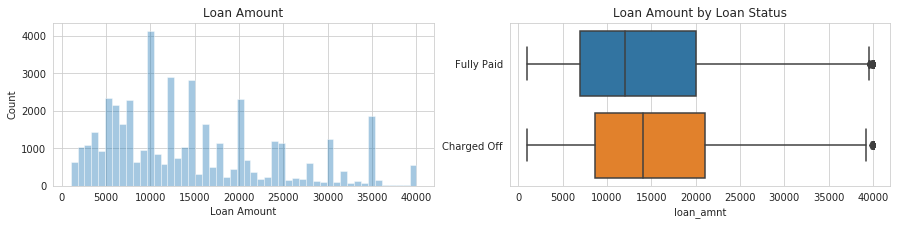

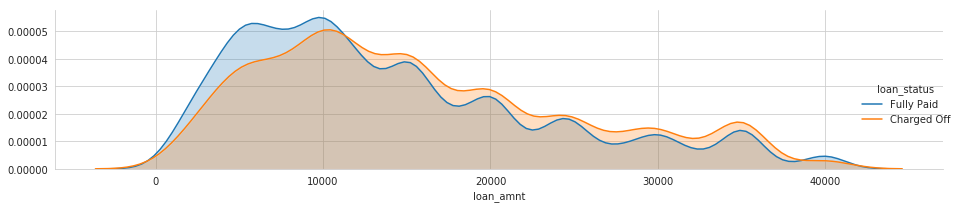

In [24]:
plot_var('loan_amnt', 'Loan Amount', continuous=True)

In [25]:
df['term'].sample(5)

67847     36 months
88687     36 months
85339     36 months
50662     36 months
81202     60 months
Name: term, dtype: object

In [26]:
df['term'].value_counts(dropna=False)

 36 months    34822
 60 months     9877
Name: term, dtype: int64

In [27]:
df['term'] = df['term'].apply(lambda s: np.int8(s.split()[0]))

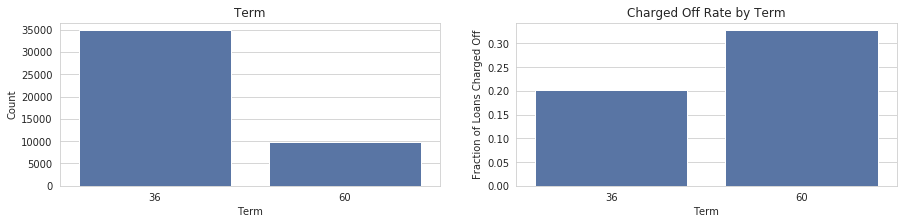

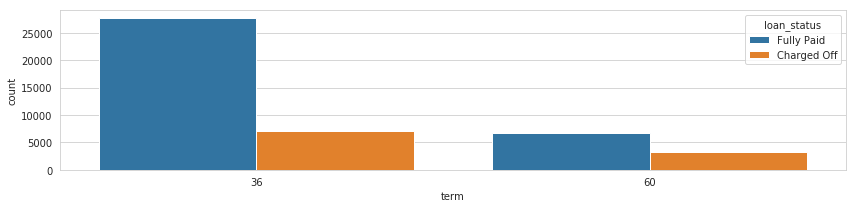

In [28]:
plot_var('term', 'Term', continuous=False)

In [29]:
df['term'].value_counts(normalize=True)

36    0.779033
60    0.220967
Name: term, dtype: float64

In [30]:
df.groupby('term')['loan_status'].value_counts(normalize=True).loc[:,'Charged Off']

term
36    0.201338
60    0.326921
Name: loan_status, dtype: float64

In [31]:
df['int_rate']= df['int_rate'].astype(str)
df['int_rate'] = df['int_rate'].apply(lambda s: np.str(s.split('%')[0]))
df['int_rate']= df['int_rate'].astype(float)
df['int_rate'].describe()

count    44699.000000
mean        13.933053
std          5.436890
min          5.320000
25%         11.390000
50%         12.740000
75%         15.990000
max         30.990000
Name: int_rate, dtype: float64

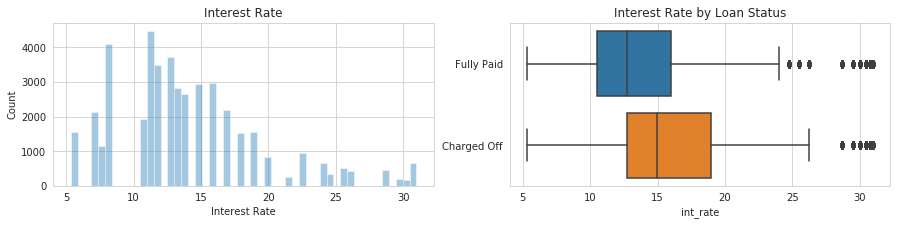

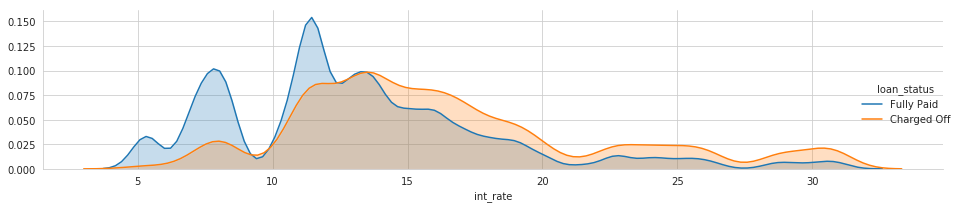

In [32]:
plot_var('int_rate', 'Interest Rate', continuous=True)

In [33]:
df['installment'].describe()

count    44699.000000
mean       452.562509
std        290.398032
min         30.120000
25%        239.210000
50%        372.210000
75%        607.820000
max       1715.420000
Name: installment, dtype: float64

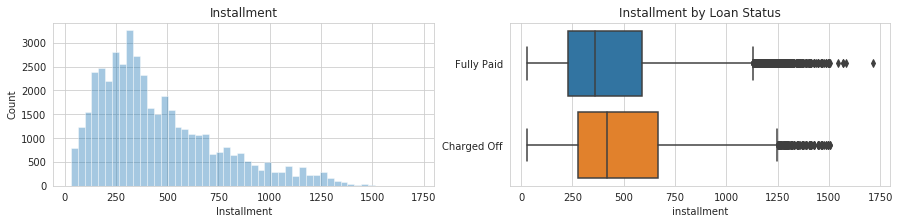

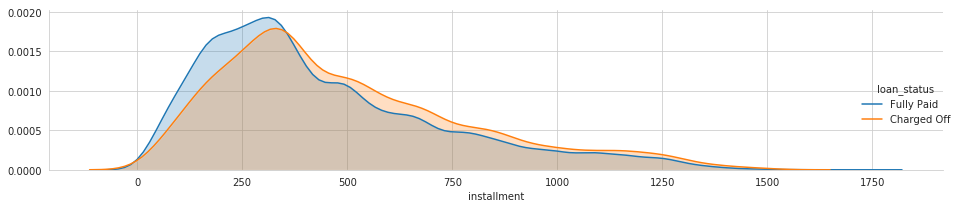

In [34]:
plot_var('installment', 'Installment', continuous=True)

In [35]:
df.groupby('loan_status')['installment'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,10240.0,495.824440,297.327275,30.99,277.29,418.74,665.8225,1504.85
Fully Paid,34459.0,439.706588,287.057275,30.12,230.61,361.38,590.5650,1715.42


In [36]:
sorted(df['grade'].unique())

['A', 'B', 'C', 'D', 'E', 'F', 'G']

In [37]:
print(sorted(df['sub_grade'].unique()))

['A1', 'A2', 'A3', 'A4', 'A5', 'B1', 'B2', 'B3', 'B4', 'B5', 'C1', 'C2', 'C3', 'C4', 'C5', 'D1', 'D2', 'D3', 'D4', 'D5', 'E1', 'E2', 'E3', 'E4', 'E5', 'F1', 'F2', 'F3', 'F4', 'F5', 'G1', 'G2', 'G3', 'G4', 'G5']


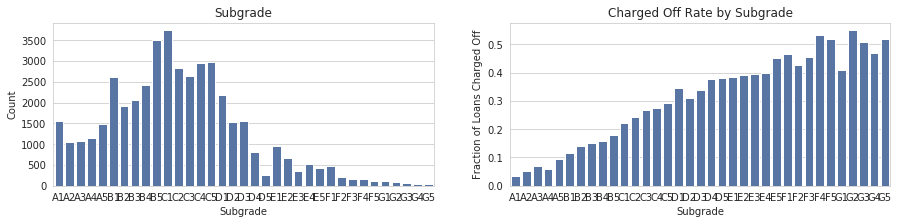

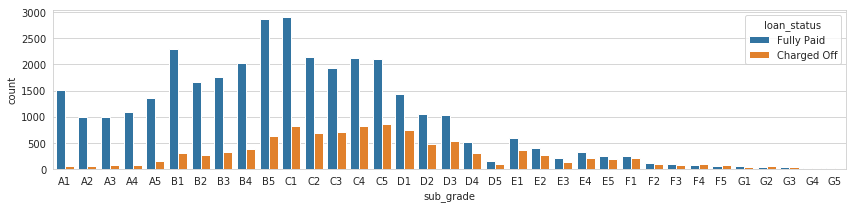

In [38]:
plot_var('sub_grade','Subgrade',continuous=False)

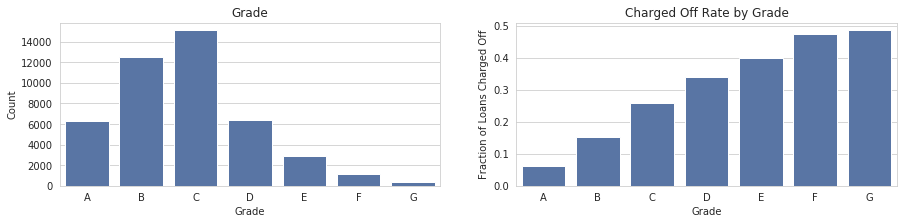

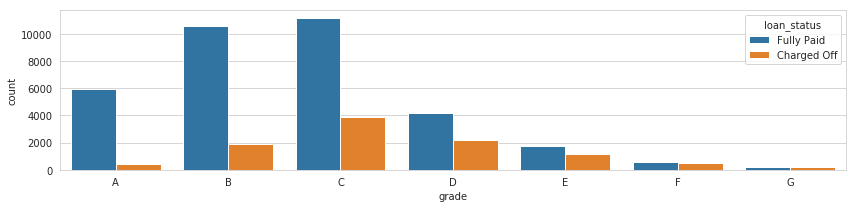

In [39]:
plot_var('grade','Grade',continuous=False)

In [40]:
#df.drop(labels='grade',axis=1,inplace=True)
drop_cols('grade')

In [41]:
df['emp_title'].describe()

count       41570
unique      19013
top       Teacher
freq          804
Name: emp_title, dtype: object

In [42]:
df['emp_title'].sample(5)

251       Chief Operating Officer
13454    Radiation Safety Officer
9363        Technical  consultant
92187                  Pharmacist
45984       Sr General Accountant
Name: emp_title, dtype: object

In [43]:
drop_cols('emp_title')

In [44]:
df['emp_length'].value_counts(dropna=False).sort_index()

1 year        3020
10+ years    15092
2 years       4308
3 years       3788
4 years       2663
5 years       2874
6 years       1991
7 years       1517
8 years       1452
9 years       1667
< 1 year      3247
NaN           3080
Name: emp_length, dtype: int64

In [45]:
df['emp_length'].replace('10+ years', '10 years', inplace=True)

In [46]:
df['emp_length'].replace('< 1 year', '0 years', inplace=True)

In [47]:
df['emp_length'].value_counts(dropna=False).sort_index()

0 years      3247
1 year       3020
10 years    15092
2 years      4308
3 years      3788
4 years      2663
5 years      2874
6 years      1991
7 years      1517
8 years      1452
9 years      1667
NaN          3080
Name: emp_length, dtype: int64

In [48]:
df.emp_length.map( lambda x: str(x).split()[0]).value_counts(dropna=True).sort_index()

0       3247
1       3020
10     15092
2       4308
3       3788
4       2663
5       2874
6       1991
7       1517
8       1452
9       1667
nan     3080
Name: emp_length, dtype: int64

In [49]:
df['emp_length'] = df.emp_length.map( lambda x: float(str(x).split()[0]))

In [50]:
df['emp_length'].sample(5)

39070    10.0
22074    10.0
44588     0.0
34829    10.0
81903    10.0
Name: emp_length, dtype: float64

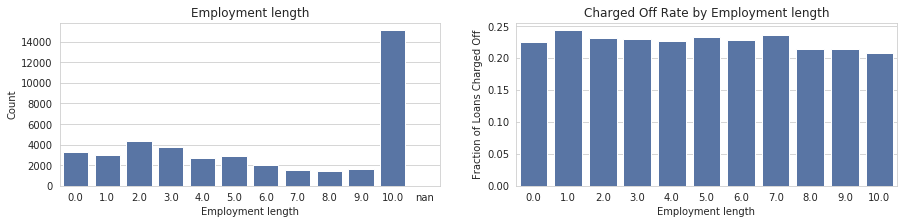

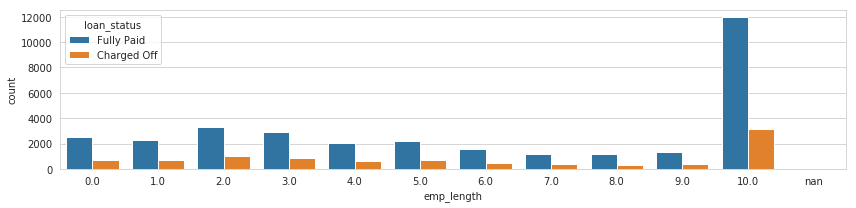

In [51]:
plot_var('emp_length', 'Employment length', continuous=False)

In [52]:
df['home_ownership'].value_counts()

MORTGAGE    22588
RENT        16745
OWN          5179
ANY           186
NONE            1
Name: home_ownership, dtype: int64

In [53]:
df['home_ownership'].replace(['NONE','ANY'],'OTHER', inplace=True)

In [54]:
df['home_ownership'].value_counts()

MORTGAGE    22588
RENT        16745
OWN          5179
OTHER         187
Name: home_ownership, dtype: int64

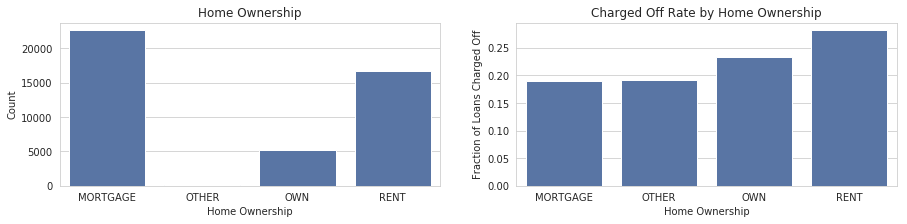

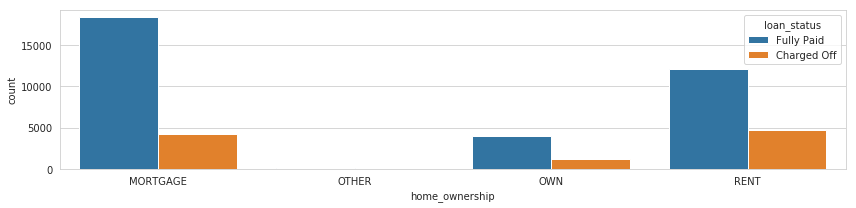

In [55]:
plot_var('home_ownership', 'Home Ownership', continuous=False)

In [56]:
df.groupby('home_ownership')['loan_status'].value_counts(normalize=True).loc[:,'Charged Off']

home_ownership
MORTGAGE    0.189393
OTHER       0.192513
OWN         0.234215
RENT        0.281457
Name: loan_status, dtype: float64

In [57]:
df['annual_inc'].describe()

count    4.469900e+04
mean     8.067236e+04
std      8.056469e+04
min      0.000000e+00
25%      4.965000e+04
50%      6.900000e+04
75%      9.700000e+04
max      9.522972e+06
Name: annual_inc, dtype: float64

In [58]:
df['annual_inc'] = df['annual_inc'].apply(lambda x:np.log10(x+1))

In [59]:
df['annual_inc'].describe()

count    44699.000000
mean         4.837498
std          0.248419
min          0.000000
25%          4.695928
50%          4.838855
75%          4.986776
max          6.978773
Name: annual_inc, dtype: float64

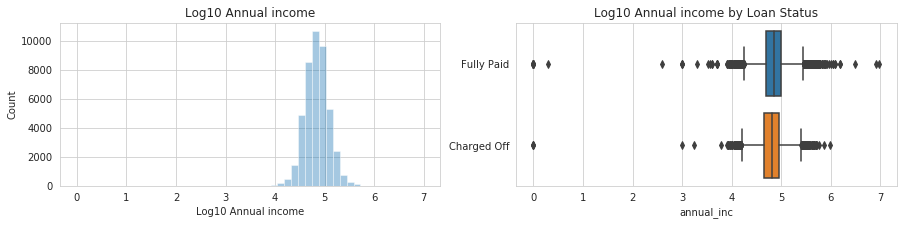

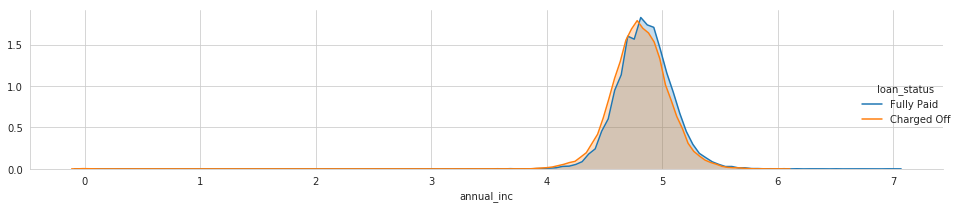

In [60]:
plot_var('annual_inc', 'Log10 Annual income', continuous=True)

In [61]:
df.groupby('loan_status')['annual_inc'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,10240.0,4.806704,0.251302,0.0,4.653222,4.812920,4.954247,5.992112
Fully Paid,34459.0,4.846649,0.246820,0.0,4.698979,4.845104,5.000004,6.978773


In [62]:
df['verification_status'].value_counts()

Source Verified    18418
Not Verified       13164
Verified           13117
Name: verification_status, dtype: int64

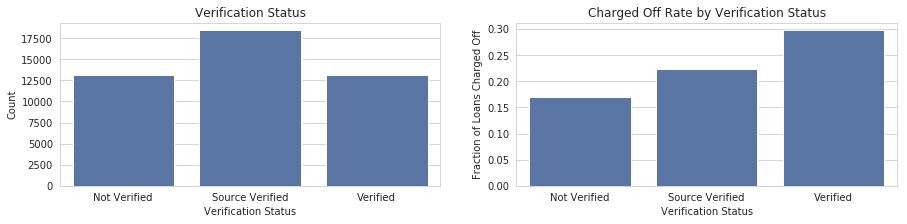

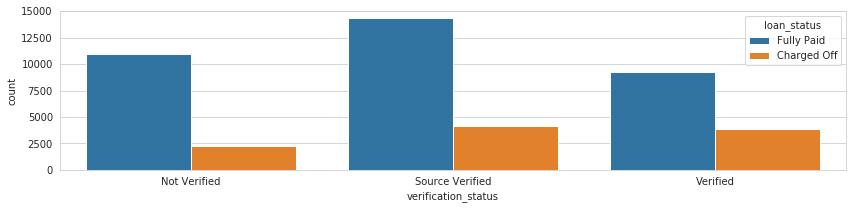

In [63]:
plot_var('verification_status', 'Verification Status', continuous=False)

In [64]:
df['purpose'].value_counts()

debt_consolidation    25722
credit_card            9044
home_improvement       3350
other                  2882
major_purchase         1005
medical                 649
car                     541
small_business          501
vacation                385
moving                  342
house                   242
renewable_energy         36
Name: purpose, dtype: int64

In [65]:
df.groupby('purpose')['loan_status'].value_counts(normalize=True)[:,'Charged Off'].sort_values(ascending=False)

purpose
small_business        0.329341
medical               0.263482
other                 0.241846
vacation              0.241558
debt_consolidation    0.240339
house                 0.231405
moving                0.219298
major_purchase        0.214925
credit_card           0.202786
home_improvement      0.196418
renewable_energy      0.166667
car                   0.160813
Name: loan_status, dtype: float64

In [66]:
df['title'].describe()

count                  44699
unique                    12
top       Debt consolidation
freq                   25718
Name: title, dtype: object

In [67]:
df['title'].value_counts().head(10)

Debt consolidation         25718
Credit card refinancing     9049
Home improvement            3349
Other                       2882
Major purchase              1003
Medical expenses             649
Car financing                542
Business                     502
Vacation                     385
Moving and relocation        342
Name: title, dtype: int64

In [68]:
drop_cols('title')

In [69]:
df['zip_code'].describe()

count     44698
unique      845
top       945xx
freq        503
Name: zip_code, dtype: object

In [70]:
df['addr_state'].describe()

count     44699
unique       49
top          CA
freq       6579
Name: addr_state, dtype: object

In [71]:
drop_cols('zip_code')

In [72]:
df.groupby('addr_state')['loan_status'].value_counts(normalize=True)[:,'Charged Off'].sort_values(ascending=False)

addr_state
AK    0.336735
MS    0.321569
NE    0.312796
OK    0.306878
DE    0.292683
LA    0.271457
NJ    0.266134
NY    0.261357
AR    0.253049
MI    0.252244
MO    0.248921
MD    0.246801
NM    0.245283
TX    0.244681
NV    0.244265
SD    0.240506
AL    0.239623
MT    0.238095
FL    0.236098
IN    0.233903
ND    0.232558
CA    0.231798
KY    0.231738
MA    0.230061
OH    0.227532
PA    0.222450
TN    0.221607
NC    0.220820
VA    0.219852
CT    0.217949
IL    0.217391
KS    0.210191
MN    0.208140
WI    0.205342
AZ    0.203055
UT    0.191601
CO    0.187612
HI    0.187251
NH    0.180258
WY    0.179775
ID    0.176871
GA    0.174981
WA    0.172635
SC    0.172084
RI    0.159624
OR    0.158940
VT    0.155556
ME    0.143885
DC    0.116279
Name: loan_status, dtype: float64

In [73]:
df['dti'].describe()

count    44687.000000
mean        18.405829
std         13.424072
min         -1.000000
25%         12.030000
50%         17.730000
75%         24.090000
max        999.000000
Name: dti, dtype: float64

Text(0.5,1,'DTI by loan status')

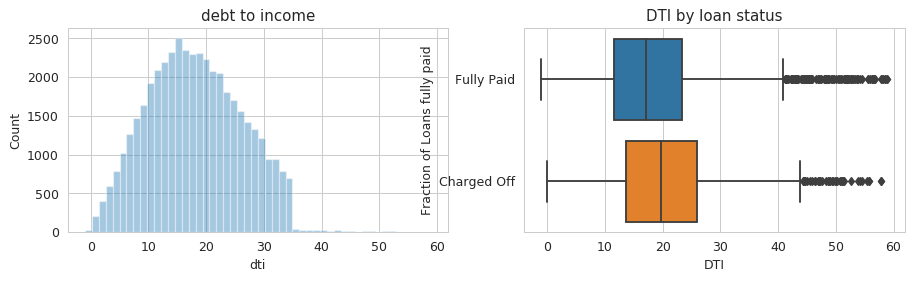

In [74]:
f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,3), dpi=90)
sns.distplot(df.loc[df['dti'].notnull() & (df['dti'] < 60), 'dti'], kde=False, ax=ax1)
ax1.set_xlabel('dti')
ax1.set_ylabel('Count')
ax1.set_title('debt to income')
sns.boxplot(x=df.loc[df['dti'].notnull() & (df['dti'] < 60), 'dti'], y='loan_status', data=df, ax=ax2)
ax2.set_xlabel('DTI')
ax2.set_ylabel('Fraction of Loans fully paid')
ax2.set_title('Fully paid rate by debt to income')
ax2.set_title('DTI by loan status')

In [75]:
(df['dti'] > 40).sum() / (df['dti']).sum()

0.00032340375596015796

In [76]:
(df['dti'] > 40).sum()

266

Very few (0.01%) outliers with dti > 60. 
From the figure it seems that the Charged Off loans have higher DTI. Let's check. 

In [77]:
df.groupby('loan_status')['dti'].median()

loan_status
Charged Off    19.790
Fully Paid     17.155
Name: dti, dtype: float64

In [78]:
df['open_acc'].describe()

count    44699.000000
mean        11.825142
std          5.730141
min          1.000000
25%          8.000000
50%         11.000000
75%         15.000000
max         72.000000
Name: open_acc, dtype: float64

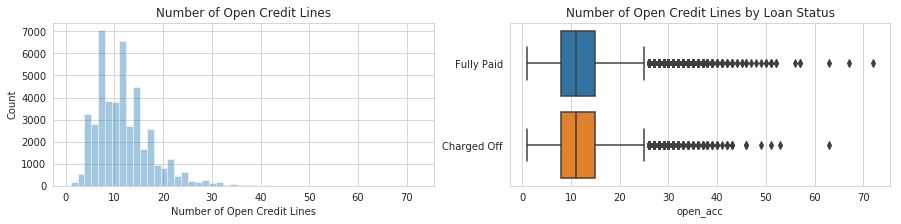

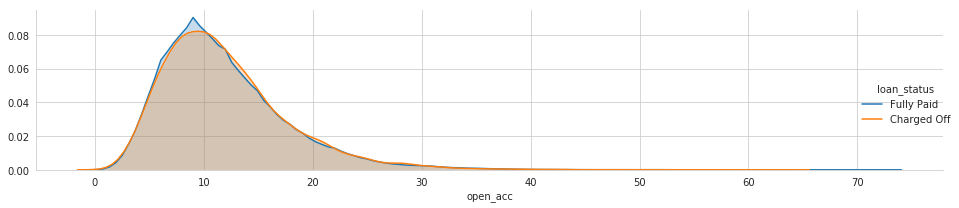

In [79]:
plot_var('open_acc', 'Number of Open Credit Lines', continuous=True)

In [80]:
df.groupby('loan_status')['open_acc'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,10240.0,11.925781,5.745214,1.0,8.0,11.0,15.0,63.0
Fully Paid,34459.0,11.795235,5.725397,1.0,8.0,11.0,15.0,72.0


In [81]:
df['earliest_cr_line'].sample(5)

27067    Dec-1997
80564    Sep-1998
64778    Apr-2008
37343    May-2004
79471    Sep-2005
Name: earliest_cr_line, dtype: object

In [82]:
df['earliest_cr_line'].describe()

count        44699
unique         582
top       Sep-2004
freq           380
Name: earliest_cr_line, dtype: object

In [83]:
df['earliest_cr_line'].isnull().any()

False

In [84]:
from datetime import datetime

df.earliest_cr_line = pd.to_datetime(df.earliest_cr_line)

dttoday = datetime.now().strftime('%Y-%m-%d')
df.earliest_cr_line = df.earliest_cr_line.apply(lambda x:(np.timedelta64((x - pd.Timestamp(dttoday)),'D').astype(int))/-365)

df.earliest_cr_line.shape

(44699,)

In [85]:
df.earliest_cr_line.sample(5)

87810    34
11579    15
25645    12
88749    19
79971    29
Name: earliest_cr_line, dtype: int64

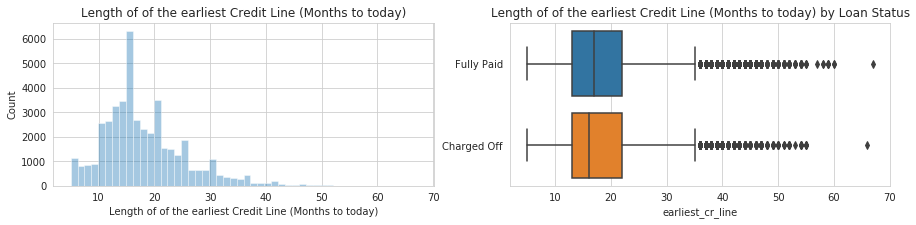

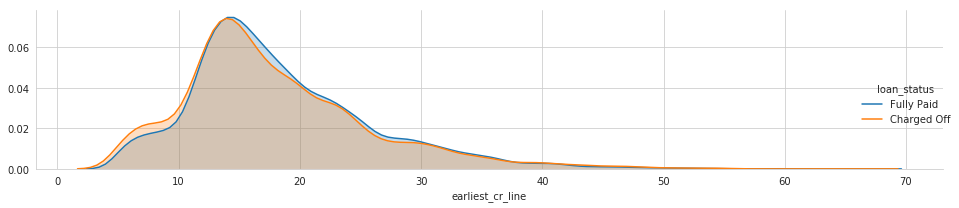

In [86]:
plot_var('earliest_cr_line', 'Length of of the earliest Credit Line (Months to today)', continuous=True)

In [87]:
df.groupby('loan_status')['earliest_cr_line'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,10240.0,17.919336,7.817327,5.0,13.0,16.0,22.0,66.0
Fully Paid,34459.0,18.328564,7.505515,5.0,13.0,17.0,22.0,67.0


In [88]:
df['pub_rec'].describe()

count    44699.000000
mean         0.281908
std          0.687921
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         28.000000
Name: pub_rec, dtype: float64

In [89]:
df['pub_rec'].value_counts().sort_values(ascending=False)

0.0     35097
1.0      7828
2.0      1159
3.0       342
4.0       139
5.0        63
6.0        35
7.0        17
8.0         5
9.0         4
11.0        2
12.0        2
19.0        1
20.0        1
14.0        1
28.0        1
16.0        1
10.0        1
Name: pub_rec, dtype: int64

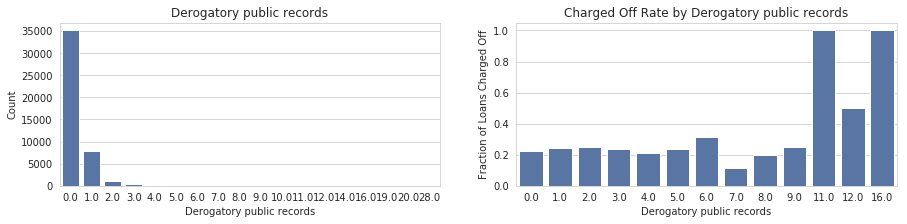

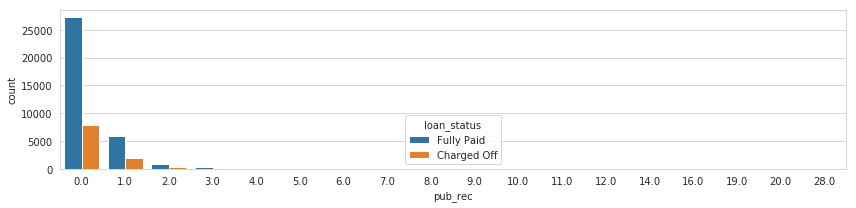

In [90]:
plot_var('pub_rec','Derogatory public records', continuous=False)

In [91]:
df.groupby('loan_status')['pub_rec'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,10240.0,0.301465,0.699391,0.0,0.0,0.0,0.0,16.0
Fully Paid,34459.0,0.276096,0.684378,0.0,0.0,0.0,0.0,28.0


In [92]:
df.pub_rec = df.pub_rec.map(lambda x: 3 if x >2.0 else x)

In [93]:
df['pub_rec'].value_counts().sort_values(ascending=False)

0.0    35097
1.0     7828
2.0     1159
3.0      615
Name: pub_rec, dtype: int64

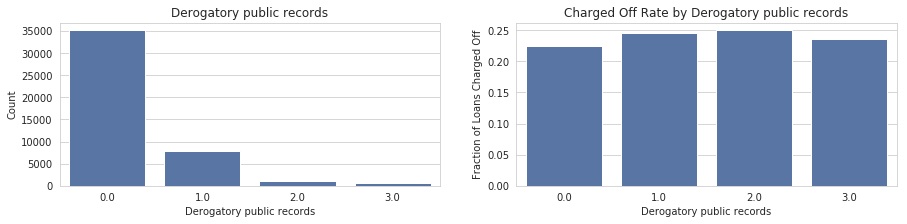

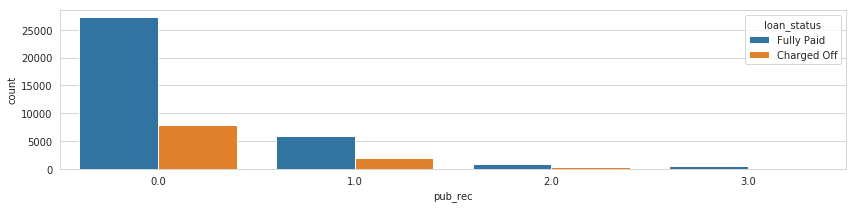

In [94]:
plot_var('pub_rec','Derogatory public records', continuous=False)

In [95]:
df.groupby('loan_status')['pub_rec'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,10240.0,0.286914,0.588247,0.0,0.0,0.0,0.0,3.0
Fully Paid,34459.0,0.262718,0.570997,0.0,0.0,0.0,0.0,3.0


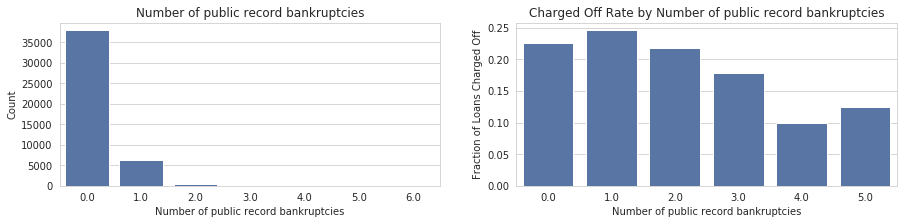

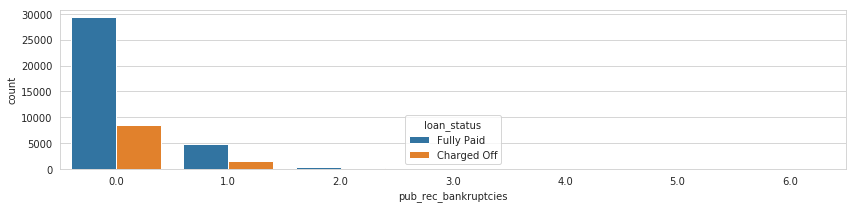

In [96]:
plot_var('pub_rec_bankruptcies', 'Number of public record bankruptcies', continuous=False)

In [97]:
df[['pub_rec','pub_rec_bankruptcies']].corr()

,pub_rec,pub_rec_bankruptcies
pub_rec,1.000000,0.706778
pub_rec_bankruptcies,0.706778,1.000000


In [98]:
df['revol_bal'].describe()

count     44699.000000
mean      16298.488892
std       21833.440441
min           0.000000
25%        6002.000000
50%       11070.000000
75%       19497.000000
max      765289.000000
Name: revol_bal, dtype: float64

In [99]:
df['revol_bal'] = df['revol_bal'].apply(lambda x:np.log10(x+1))

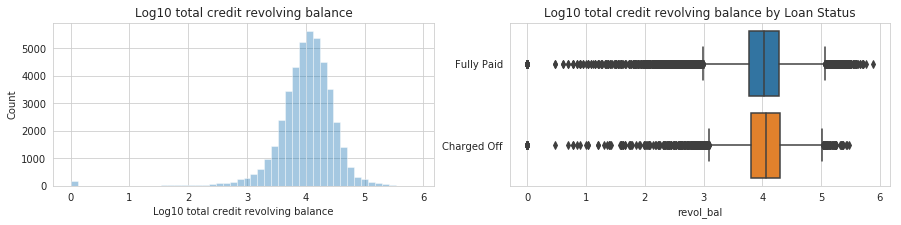

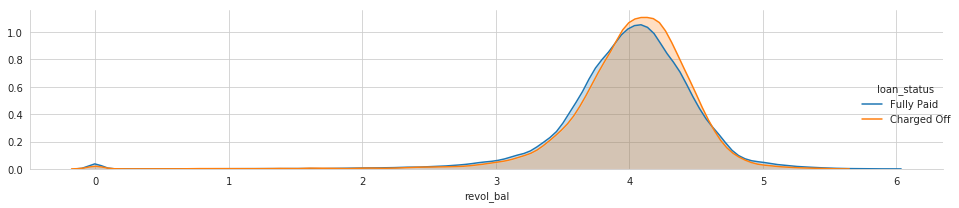

In [100]:
plot_var('revol_bal', 'Log10 total credit revolving balance', continuous=True)

In [101]:
df['revol_util'].describe()
df['revol_util']= df['revol_util'].astype(str)
df['revol_util'] = df['revol_util'].apply(lambda s: np.str(s.split('%')[0]))
df['revol_util']= df['revol_util'].astype(float)
df['revol_util'].describe()

count    44679.000000
mean        48.129891
std         24.283511
min          0.000000
25%         29.600000
50%         47.400000
75%         66.100000
max        123.500000
Name: revol_util, dtype: float64

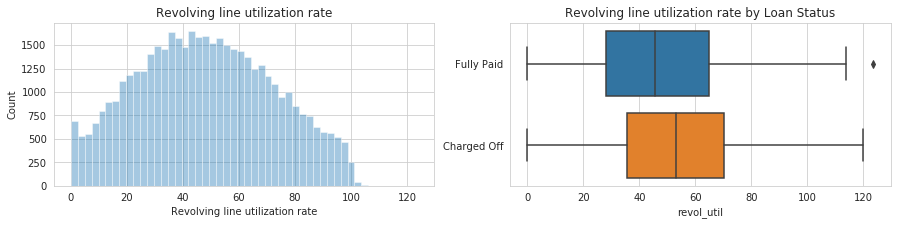

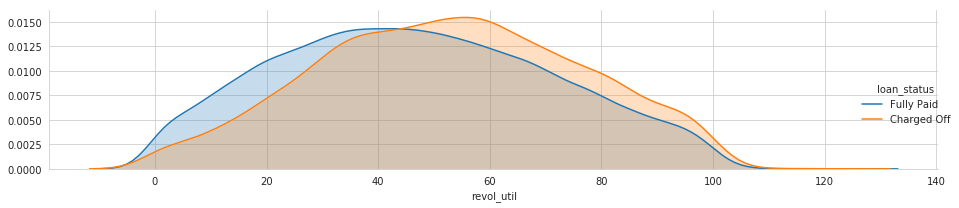

In [102]:
plot_var('revol_util', 'Revolving line utilization rate', continuous=True)

In [103]:
df.groupby('loan_status')['revol_util'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,10234.0,52.957241,23.357801,0.0,35.7,53.0,70.2,120.0
Fully Paid,34445.0,46.695631,24.368573,0.0,27.9,45.6,64.8,123.5


Charged Off loans tend to have higher revol_util.

In [104]:
df['total_acc'].describe()

count    44699.000000
mean        24.652274
std         12.105899
min          2.000000
25%         16.000000
50%         23.000000
75%         31.000000
max        144.000000
Name: total_acc, dtype: float64

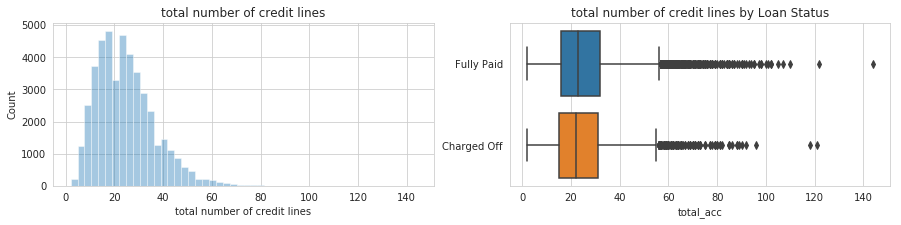

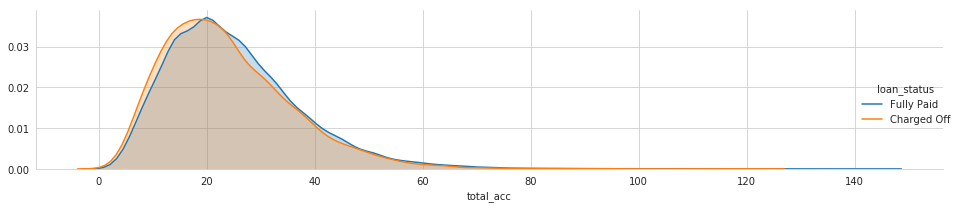

In [105]:
plot_var('total_acc', 'total number of credit lines', continuous=True)

In [106]:
df['initial_list_status'].value_counts()

w    30630
f    14069
Name: initial_list_status, dtype: int64

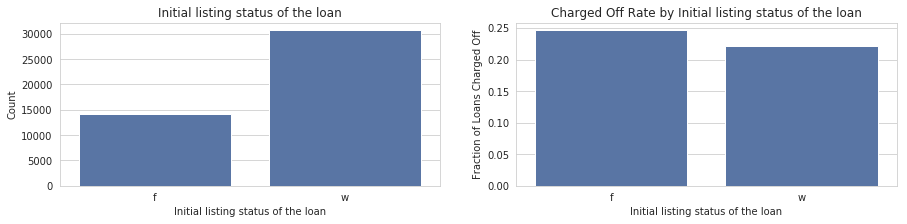

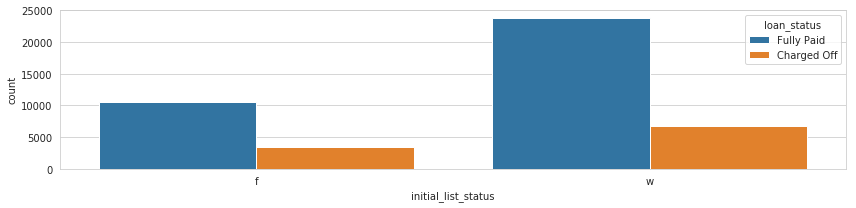

In [107]:
plot_var('initial_list_status','Initial listing status of the loan', continuous=False)

In [108]:
df['policy_code'].value_counts()

1.0    44699
Name: policy_code, dtype: int64

In [109]:
drop_cols('policy_code')

In [110]:
df['application_type'].value_counts()

Individual    42889
Joint App      1810
Name: application_type, dtype: int64

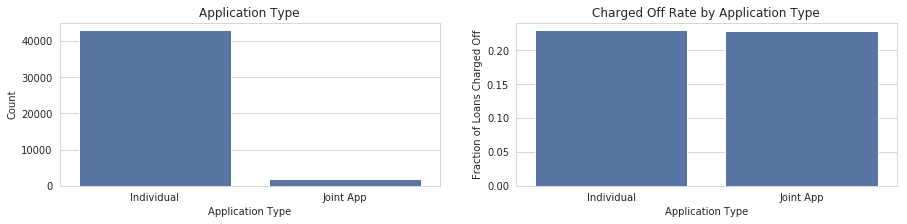

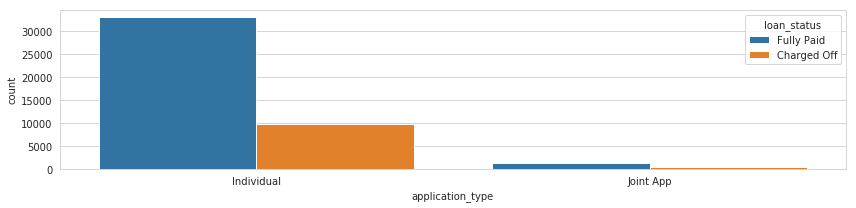

In [111]:
plot_var('application_type', 'Application Type', continuous=False)

In [112]:
df['mo_sin_old_il_acct'].describe()

count    43635.000000
mean       124.974470
std         52.578255
min          0.000000
25%         98.000000
50%        129.000000
75%        152.000000
max        665.000000
Name: mo_sin_old_il_acct, dtype: float64

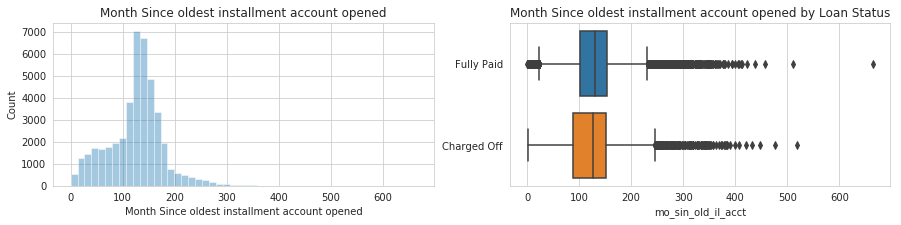

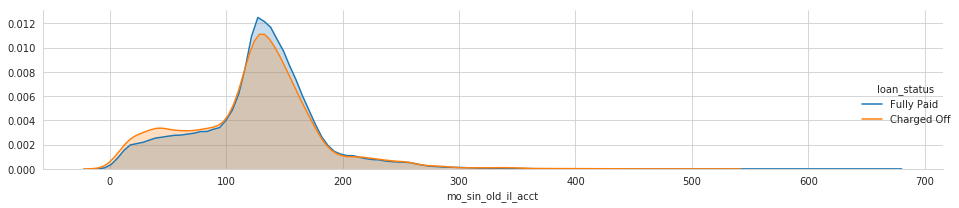

In [113]:
plot_var('mo_sin_old_il_acct', 'Month Since oldest installment account opened', continuous=True)

In [114]:
df['mo_sin_old_rev_tl_op'].describe()

count    44699.000000
mean       181.155731
std         96.550875
min         10.000000
25%        118.000000
50%        163.000000
75%        231.000000
max        781.000000
Name: mo_sin_old_rev_tl_op, dtype: float64

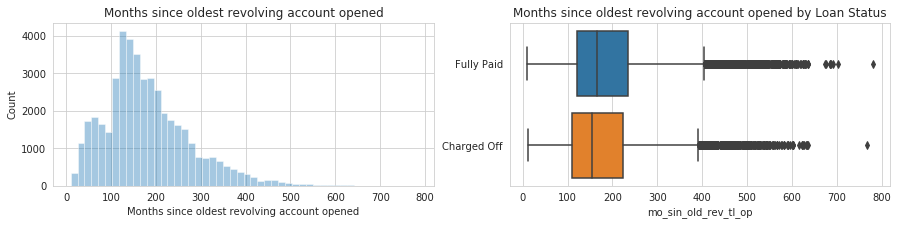

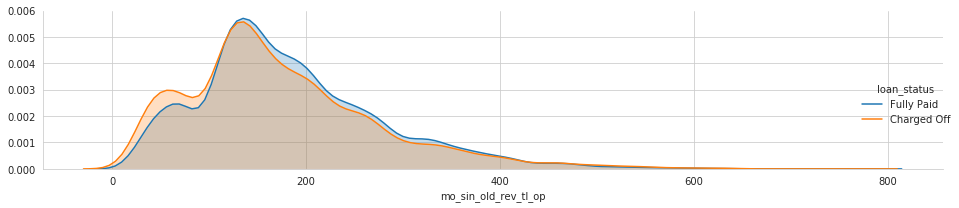

In [115]:
plot_var('mo_sin_old_rev_tl_op', 'Months since oldest revolving account opened', continuous=True)

In [116]:
df['mort_acc'].describe()

count    44699.000000
mean         1.576657
std          1.851470
min          0.000000
25%          0.000000
50%          1.000000
75%          3.000000
max         22.000000
Name: mort_acc, dtype: float64

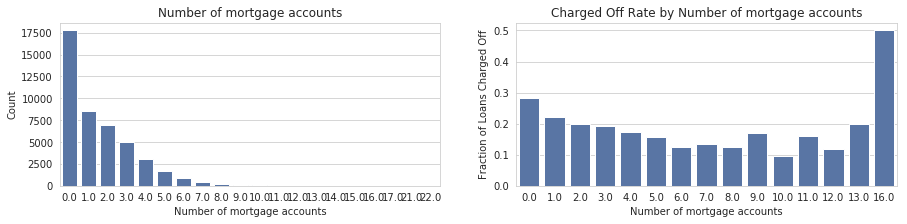

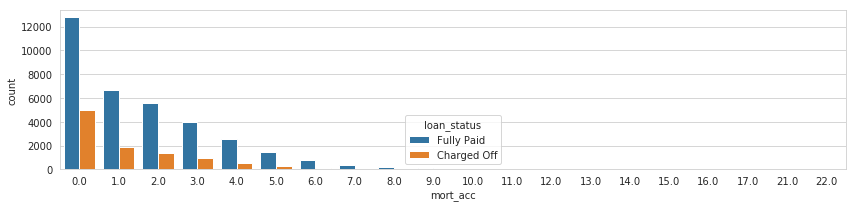

In [117]:
plot_var('mort_acc', 'Number of mortgage accounts', continuous=False)

In [118]:
df.mort_acc = df.mort_acc.map(lambda x: 6.0 if x > 6.0 else x)

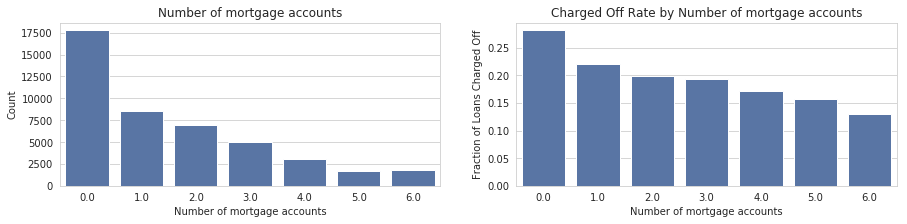

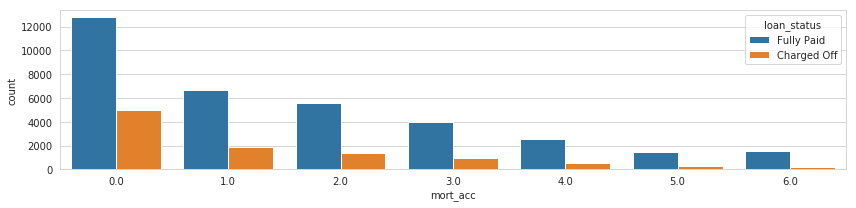

In [119]:
plot_var('mort_acc', 'Number of mortgage accounts', continuous=False)


In [120]:
df.groupby('loan_status')['mort_acc'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,10240.0,1.205078,1.548618,0.0,0.0,1.0,2.0,6.0
Fully Paid,34459.0,1.634667,1.744354,0.0,0.0,1.0,3.0,6.0


In [121]:
df['Charged_Off'] = df['loan_status'].apply(lambda s: np.float(s == 'Charged Off'))
drop_cols('loan_status')

In [122]:
df.sample(5)

,loan_amnt,term,int_rate,installment,sub_grade,emp_length,home_ownership,annual_inc,verification_status,issue_d,...,max_bal_bc,all_util,inq_fi,total_cu_tl,inq_last_12m,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mort_acc,pub_rec_bankruptcies,Charged_Off
61134,25200.0,60,25.49,746.92,E4,1.0,MORTGAGE,4.863329,Not Verified,Feb-2017,...,4063.0,85.0,3.0,2.0,4.0,119.0,80.0,2.0,1.0,0.0
47268,35000.0,36,18.99,1282.79,D3,10.0,MORTGAGE,4.977728,Verified,Feb-2017,...,6822.0,83.0,2.0,2.0,0.0,103.0,118.0,5.0,0.0,1.0
60607,12300.0,36,6.99,379.74,A2,NaN,MORTGAGE,4.725920,Verified,Feb-2017,...,4516.0,41.0,0.0,0.0,1.0,46.0,312.0,2.0,1.0,0.0
42675,14000.0,36,11.39,460.94,B3,0.0,MORTGAGE,4.812920,Source Verified,Feb-2017,...,7489.0,57.0,1.0,1.0,4.0,141.0,240.0,2.0,0.0,0.0
33173,10000.0,36,12.74,335.69,C1,4.0,RENT,4.875067,Not Verified,Mar-2017,...,2285.0,64.0,1.0,0.0,3.0,109.0,40.0,0.0,0.0,0.0


In [123]:
dummy_list =['sub_grade','home_ownership','verification_status','purpose','addr_state','initial_list_status','application_type']

In [124]:
df[dummy_list].isnull().any()

sub_grade              False
home_ownership         False
verification_status    False
purpose                False
addr_state             False
initial_list_status    False
application_type       False
dtype: bool

In [125]:
df = pd.get_dummies(df, columns=dummy_list, drop_first=True)

In [126]:
df.shape

(44699, 134)

In [127]:
df.head(1)

,loan_amnt,term,int_rate,installment,emp_length,annual_inc,issue_d,dti,earliest_cr_line,mths_since_last_delinq,...,addr_state_TN,addr_state_TX,addr_state_UT,addr_state_VA,addr_state_VT,addr_state_WA,addr_state_WI,addr_state_WY,initial_list_status_w,application_type_Joint App
0,16000.0,60,12.74,361.93,10.0,5.113947,Mar-2017,8.28,23,42.0,...,0,0,0,0,0,0,0,0,1,0


In [128]:
df['issue_d'].sample(5)

3835     Mar-2017
43795    Feb-2017
62766    Feb-2017
79593    Jan-2017
47167    Feb-2017
Name: issue_d, dtype: object

In [129]:
df['issue_d'].isnull().any()

False

"issue_d" has month and year, no null values.

In [130]:
df['issue_d'] = pd.to_datetime(df['issue_d'])

In [131]:
df['issue_d'].sample()

79752   2017-01-01
Name: issue_d, dtype: datetime64[ns]

In [132]:
df['issue_d'].describe()

count                   44699
unique                      3
top       2017-03-01 00:00:00
freq                    16128
first     2017-01-01 00:00:00
last      2017-03-01 00:00:00
Name: issue_d, dtype: object

Text(0.5,1,'Loans funded per month')

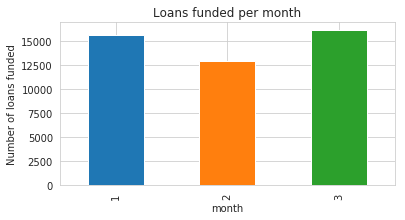

In [133]:
plt.figure(figsize=(6,3))
df['issue_d'].dt.month.value_counts().sort_index().plot.bar()
plt.xlabel('month')
plt.ylabel('Number of loans funded')
plt.title('Loans funded per month')

In [134]:
df_train = df.loc[df['issue_d']  < df['issue_d'].quantile(0.5)]
df_test =  df.loc[df['issue_d'] >= df['issue_d'].quantile(0.5)]

In [135]:
print('Number of loans in the partition:   ', df_train.shape[0] + df_test.shape[0])
print('Number of loans in the full dataset:', df.shape[0])

('Number of loans in the partition:   ', 44699)
('Number of loans in the full dataset:', 44699)


In [136]:
df_train['Charged_Off'].describe()

count    15668.000000
mean         0.226449
std          0.418546
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: Charged_Off, dtype: float64

In [137]:
df_test['Charged_Off'].describe()

count    29031.000000
mean         0.230512
std          0.421168
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: Charged_Off, dtype: float64

In [138]:
df_train.drop('issue_d', axis=1, inplace=True)
df_test.drop('issue_d', axis=1, inplace=True)

In [139]:
X_train = df_train.drop(['Charged_Off'], axis=1)
y_train = df_train.loc[:, 'Charged_Off']

X_test = df_test.drop(['Charged_Off'], axis=1)
y_test = df_test['Charged_Off']

In [140]:
X_all = df.drop(['Charged_Off'], axis=1)
Y_all = df.loc[:, 'Charged_Off']

In [141]:

from sklearn.preprocessing import Imputer, StandardScaler
imputer = Imputer(strategy='median')
imputer.fit(X_train)
X_train = pd.DataFrame(imputer.transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns)

In [142]:
missing_values_table(X_train)

Your selected dataframe has 132 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values,type


In [143]:
missing_values_table(X_test)

Your selected dataframe has 132 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values,type


In [144]:
from sklearn.preprocessing import StandardScaler

In [145]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

In [146]:
from sklearn.neighbors import KNeighborsClassifier


In [147]:
knn = KNeighborsClassifier(n_neighbors = 3)


knn.fit(X_train,y_train)
knn.predict(X_test)[100:200]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1.])

In [ ]:
K_value = 4
neigh = KNeighborsClassifier(n_neighbors = K_value, weights='uniform', algorithm='auto')
neigh.fit(X_train, y_train) 
y_pred = neigh.predict(X_test)


In [ ]:
def evaluation(X_train, X_test, Y_train, Y_test,  Y_pred):
   
    
    print("\n--- Accuracy ---")
    print(accuracy_score(Y_test, Y_pred))

    tn, fp, fn, tp = confusion_matrix(Y_test, Y_pred).ravel()
    print("\n--- Confusion Matrix ---")
    print("True Positive:", tp)
    print("False Negative:", fn)
    print("True Negative:", tn)
    print("False Positive:", fp)

    print("\n--- Precision ---")
    print( precision_score(Y_test, Y_pred))

    print("\n--- Recall ---")
    print( recall_score(Y_test, Y_pred))

    print("\n--- F1 Score ---")
    print(f1_score(Y_test, Y_pred))
      


In [ ]:

evaluation(X_train, X_test, y_train, y_test, y_pred)
